In [1]:
import sys, time, os
from pathlib import Path
import imageio
import numpy as np
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt 
from landlab.io.netcdf import (write_netcdf, read_netcdf)
from landlab import (RasterModelGrid, imshow_grid, imshowhs_grid)
from landlab.plot import graph
from landlab.components import (DepressionFinderAndRouter,
                                FastscapeEroder,
                                FlowAccumulator,
                                Space,
                                ChannelProfiler,
                                PriorityFloodFlowRouter,
                                BedrockLandslider,
                                FireGenerator)
from landlab.utils import get_watershed_mask
from landlab.io import read_esri_ascii, write_esri_ascii
from bmi_topography import Topography

%matplotlib inline

# Here figures are made larger and matplotlib warnings are suppressed for presentation purposes
plt.rcParams['figure.figsize'] = [10, 10] 
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
from IPython.display import clear_output

# Modules are autoreloaded for easy modification
%load_ext autoreload
%autoreload 2

In [2]:
# here are the new functionalities to implement randomly burned areas....

import numpy as np

class ErodibilityStepper:
    """
    This class is initialized by a decay_constant, describing the rate at which
    the erodibility of burned areas recovers, and a baseline erodibility value Ksed0.
    """
    def __init__(self, decay_time=1, K_sed0=1):
        self.decay_time = decay_time
        self.K_sed0 = K_sed0
        
    def stepper(self, space, dt):
        """
        This method takes in  a space object "space",
        an equilibrium (in the absence of burning) erodibility Ksed0,
        and a timestep "space_dt" to modify the erodibility
        of `space` on each gridcell by one timestep by the equation
        dK/dt = -decay_const*(Ksed-Ksed0). 
        Describing a decay of the erodibility toward its equilibrium
        value Ksed_0
        """
        # solve the DE with simple Euler method
        dK_sed =  -(space.K_sed-self.K_sed0)*dt/self.decay_time # erodibility decay in time
        space.K_sed += dK_sed # modify the erodibility in place
        
class Burner:
    """
    This is initialized by a fire frequency, mean fire radius in units of the grid size,
    and the amount K_sed_boost by which the sediment erodibility is increased by fire.
    The method `fire` modifies (in place) the erodibility of nodes where the fire occurred.
    """
    def __init__(self, fire_freq=1, R_fire_mean=1, K_sed_boost=1, dt = 1,dx=1):
        """
        fire frequency -- how often fires occur [1/T]
        fire radius -- typical size of fires [L]
        K_sed_boost -- amount by which K_sed is increased by fire
        dt -- space model timestep.
        """
        self.fire_freq = fire_freq # average number of fires per unit time
        self.R_fire_mean = R_fire_mean # the radius of the fire... 
        self.K_sed_boost = K_sed_boost # the amount by which the sediment erodibility is increased by fire
        self.dt = dt # the timestep on which to evaluate the probability that a fire occurs
        self.fireTimes=[] # empty list to be filled with the times when fires happened
        self.fireSizes=[] # empty list to be filled with the sizes of fires that happened
        self.dx=dx # size of the grid used by space
        
    @property
    def R_fire(self):
        """
        choose a random fire size from an exponential distribution
        having mean size R_fire_mean
        """
        return np.random.exponential(self.R_fire_mean) # exponential random var
        
        
    def fire(self, space, grid, t):
        """
        Generates a fire at a random location within the grid.
        First calculates whether or not a fire occurs at the timestep.
        Then 
        """
        # fire occurs if..
        #    a random exceeds the probability that fire does not occur
        occurs = np.exp(-self.dt*self.fire_freq) < np.random.random() # prob fire does not occur < random 
        if not occurs: # if fire does not occur...
            pass # do nothing. This comes first as it's the most common scenario.
        else: # if fire does occur
            K_sed = space.K_sed # get the array of sediment erodibilities before the fire
            # find the coordinates of this erodibility array which are to be changed
            center = np.random.choice(K_sed.size) # select a random node for the fire center
            # locate all nodes within R_fire of the center node.
            changed_nodes = self._within(center, space , grid) # based on Laurent's code.
            # modify those nodes only.. they should increase erodibility !
            K_sed[changed_nodes]+= self.K_sed_boost # increase them by K_sed_boost
            # set these into the space object as the new erodibility
            space.K_sed = K_sed # modify in place. Erodibility is now boosted by the fire.
            # This occurs on all cells within proximity R_fire of the fire center

            # just a print block to explain what's happening...
            s1 = grid.x_of_node[center]
            s2 = grid.y_of_node[center]
            A = len(changed_nodes)*self.dx**2/1e6 # area of the fire if it occcurred
            # units of A are km^2. 
            print(r'fire at ({},{}) of area {} square km.'.format(s1,s2,round(A,2)))
            
            
            # save the time and magnitude of the fire
            self.fireTimes.append(t) # time at which the fire happened
            self.fireSizes.append(A) # area of the fire which happened.
                        
        
    def _within(self,center, space, grid):
        """
        return all nodes within distance R_fire of center within grid. Utility function.
        Takes:
            center -- a single index (i.e. '3') into the 1D array of nodes
            R_fire -- the radius of a fire in gridsize units
            space -- the SPACE object (called ha..)
            grid -- the RasterModelGrid object (called mg ..)
        """
        centerPoint = (grid.x_of_node[center], grid.y_of_node[center]) # the center of the fire
        mask = grid.calc_distances_of_nodes_to_point(centerPoint) < self.R_fire # mask of nodes in radius
        # all nodes within R_fire of the centerPoint
        return np.arange(mask.size)[mask] # return indices of all nodes within distance R_fire


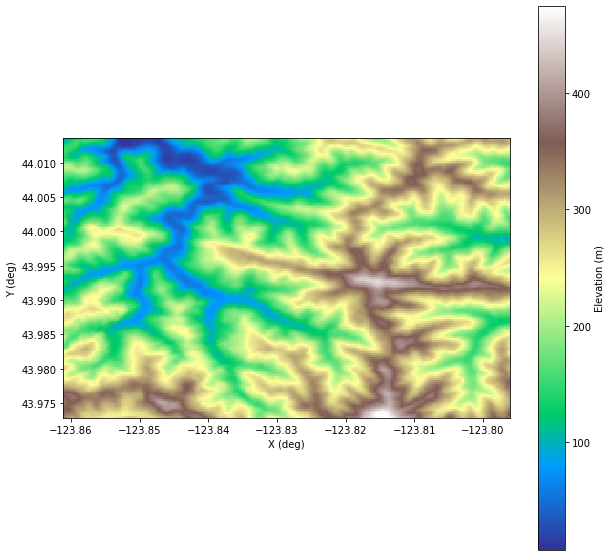

In [3]:
topo = Topography(
    dem_type="SRTMGL1",
    api_key = '1f3ea82738663688170f0d898b59ca1d',
    south=43.972829,
    north=44.013602,
    west=-123.860848,
    east=-123.795973,
    output_format="AAIGrid",
    cache_dir="DEMData//"
    )

fname = topo.fetch()
dem = topo.load()
# Read DEM as Lanlab grid
grid_geog, elev = read_esri_ascii(fname, name='topographic__elevation')    
#Show dem
plt.figure()
cmap = copy.copy(mpl.cm.get_cmap("terrain"))
imshow_grid(grid_geog, 'topographic__elevation',cmap =cmap,
            grid_units=("deg", "deg"),colorbar_label="Elevation (m)")
plt.show()

30.0


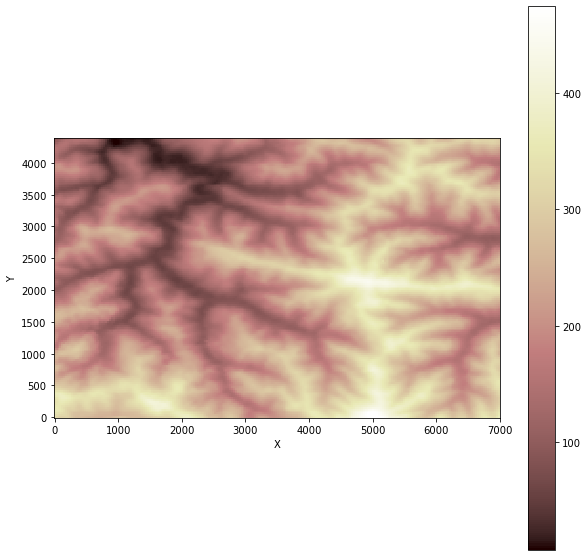

In [4]:
grid = RasterModelGrid((grid_geog.number_of_node_rows,grid_geog.number_of_node_columns),30)
grid.add_field('topographic__elevation',elev, at = 'node')
imshow_grid(grid,'topographic__elevation')
dx=np.diff(grid.x_of_node)[0]
print(dx)

In [10]:
# Saving outputs
printit = True        # be verbose with printing output our not?
save_dir = './simul/' # directory in which to save outputs
# if save directory does not exist and you are to save, make save_dir.
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

# Timesteps, runtime, and uplift rate for SPACE wildfire simulation time window
dt_sp = 1                   # timestep in years
runtime_sp = 20             # length of the simulation in years
ndt_sp = runtime_sp//dt_sp  # number of timesteps
U_sp = 0.002                # Uplift rate in m/yr

# Fastscape Eroder parameters
K_sp=0.00001            # erodibility coefficient
m_sp=0.5                # Drainage area exponent
n_sp=1                  # Slope exponent

# SPACE parameters (we will use the same K, m, and n as above)
K_sed0 = 0.00001        # Baseline soil erodiblity
K_br = 0.00001          # Bedrock erodibility coefficient
F_f = 0                 # The fraction of fine sediment that becomes suspended as washload
phi = 0                 # Sediment porosity
H_star = 1.             # Bedrock roughness scale
v_s = 0.001             # Settling length scale for entrained sediment to travel before depositing
sp_crit_sed = 0         # Critical stream power threshold required to entrain sediment
sp_crit_br = 0          # Critical stream power threshold required to erode bedrock

# Erodibility stepper
decay_time = dt_sp*15    # time it takes the erodibility perturbutions to decay

# Burner
R_fire_mean = len(grid.x_of_node)*dx/500    # Mean fire radius in m. 1/20 the size of the grid.
fire_freq = 1/(2*dt_sp)          # Fire frequency in #/yr. This is one every 10
K_sed_boost = 5*K_sed0           # The increase in sediment erodibility due to fire
K_sp=0.00001          # erodibility coefficient
m_sp=0.5              # Drainage area exponent
n_sp=1                # Slope exponent

fr = FlowAccumulator(grid, flow_director='D8')
df = DepressionFinderAndRouter(grid)

In [6]:
#Add soil to the drainage network (for SPACE)
_ = grid.add_zeros('soil__depth', at='node', dtype=float) 
grid.at_node['soil__depth'] += 0.5
grid.at_node['topographic__elevation'] += grid.at_node['soil__depth']

In [7]:
K_sed = np.ones(grid.shape)*K_sed0 # the initial soil erodibility per node
ha = Space(
    grid,
    K_sed=K_sed,
    K_br=K_br,
    F_f=F_f,
    phi=phi,
    H_star=H_star,
    v_s=v_s,
    m_sp=m_sp,
    n_sp = n_sp,
    sp_crit_sed=sp_crit_sed,
    sp_crit_br=sp_crit_br)

# Instantiate the erodibility stepper
es = ErodibilityStepper(decay_time=decay_time, K_sed0=K_sed0)
# Instantiate the burner
burner = Burner(fire_freq=fire_freq,
                R_fire_mean=R_fire_mean,
                K_sed_boost=K_sed_boost,
                dt=dt_sp)

In [11]:
start_time = time.time() # for the purposes of tracking the runtime of the simulation loop
for it in range(ndt_sp): # iterate through timesteps
    fr.run_one_step()           # accumulate the flow
    df.map_depressions()        # find landscape depressions (which do not erode)
    ha.run_one_step(dt=dt_sp)   # step the transport model
    es.stepper(ha,dt=dt_sp)     # decay the erodibility back toward baseline from the former timestep
    burner.fire(ha,grid,it*dt_sp)          # light any fires (increase erodibility)
    grid.at_node['bedrock__elevation'][grid.core_nodes] += U_sp*dt_sp # incorporate uplift
    grid.at_node['K-sed'] = K_sed
    if (it*dt_sp % 5 == 0) and printit: # if a decade has gone by, then print
        clear_output(wait=True) # jupyter functionality to print over previous output
        # let us kno how long it has been running
        print("--", it*dt_sp, "years simulated -- %s seconds runtime --" % round((time.time() - start_time), 1))

-- 15 years simulated -- 140.0 seconds runtime --


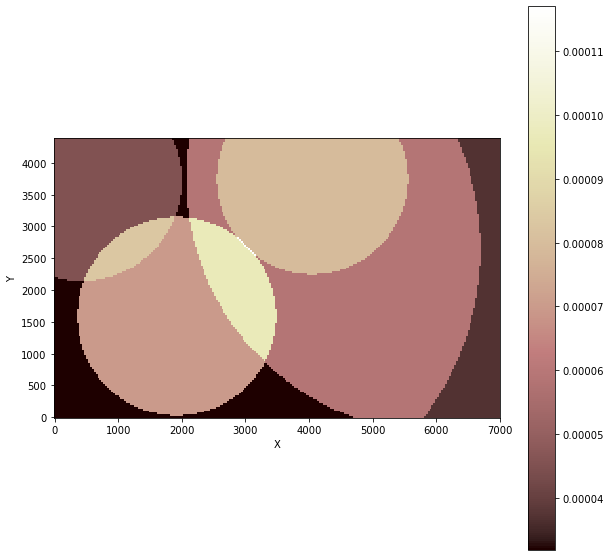

In [12]:
imshow_grid(grid,'K-sed')

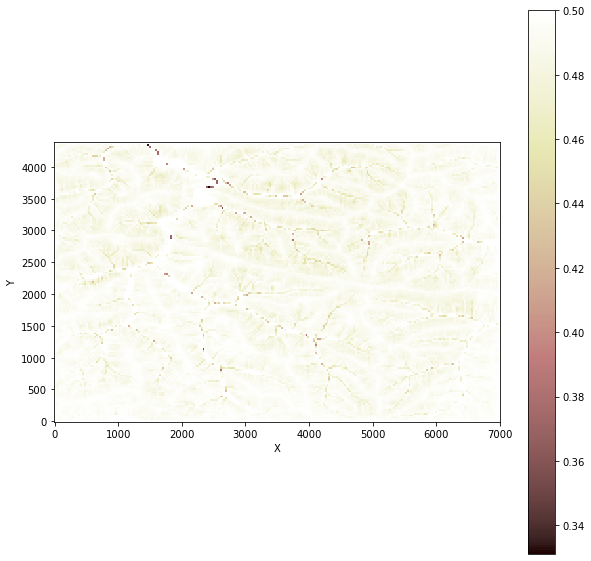

In [19]:
imshow_grid(grid,'soil__depth')

Text(0.5, 1.0, 'Fire magnitudes through time')

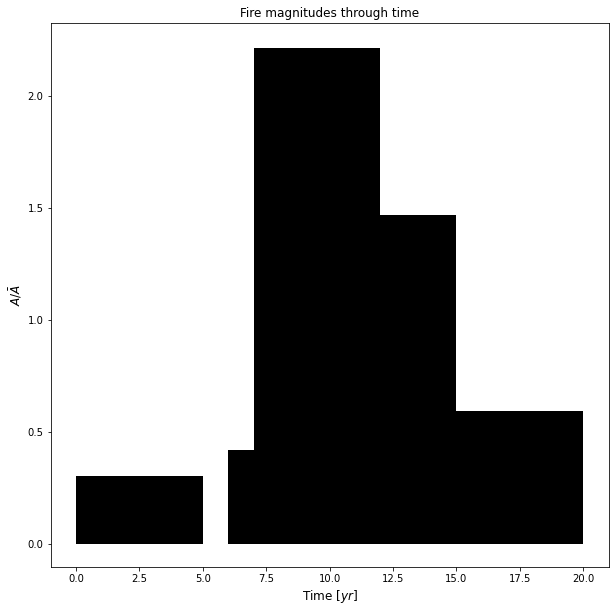

In [20]:
plt.bar(burner.fireTimes,burner.fireSizes/np.mean(burner.fireSizes), width=5, align='edge', lw=2, color='black')
plt.xlabel("Time [$yr$]",fontsize=12)
plt.ylabel(r"$A/\bar{A}$",fontsize=12)
plt.ylim(-0.1)
plt.title('Fire magnitudes through time',fontsize=12)